In [64]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [65]:
import numpy as np
import pandas as pd

In [66]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [67]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [68]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [69]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [70]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [71]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [72]:
# Crete the inspector and conect it to the engine
inspector = inspect(engine)

In [73]:
# Print the column names for "measurement" table
columns_measurement = inspector.get_columns('measurement')
for column in columns_measurement:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [74]:
# Print the column names for "station" table
columns_station = inspector.get_columns('station')
for column in columns_station:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [75]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [ ]:

# Calculate the date 1 year ago from the last data point in the database

In [91]:
# Lastest Date
lastest_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastest_day

('2017-08-23')

In [94]:
# Date 1 year ago from the last data poing in the database
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [184]:
# Perform a query to retrieve the data and precipitation scores

# Design a query to retrieve the last 12 months of precipitation data and plot the results
sel = [Measurement.date, Measurement.prcp]
last_year_precipitation = session.query(*sel).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()

Text(0.5, 1.0, 'Pcr from 08-2016 to 08-2017')

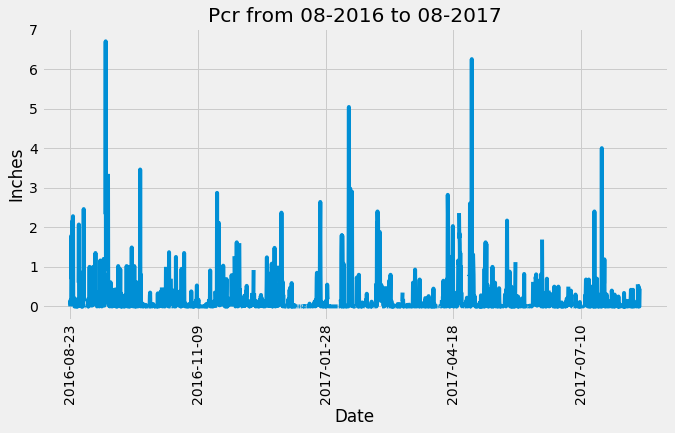

In [185]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last_year_precipitation, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
prcp_df.sort_values(by=('Date'), inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x='Date', y='Precipitation', rot=90, legend=False, figsize=(10,5))
plt.ylabel('Inches')
plt.title('Pcr from 08-2016 to 08-2017')


In [186]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [187]:
# Design a query to show how many stations are available in this dataset?

total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9)]

In [188]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_total = func.count(Measurement.station)
sel_sc= [Measurement.station,
count_total]
stations_counts = session.query(*sel_sc).group_by(Measurement.station).order_by(count_total).all()
stations_counts

[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [189]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel_281= [Measurement.station,
func.max(Measurement.tobs),
func.min(Measurement.tobs),
func.avg(Measurement.tobs)]

activate_station = session.query(*sel_281).filter(Measurement.station == 'USC00519281').all()
activate_station

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [193]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Query the last 12 months of temperature observation
sel_tobs = [Measurement.tobs, 
func.count(Measurement.tobs)]
temperature_281= session.query(Measurement.tobs).filter(Measurement.date >='2016-08-23').filter(Measurement.station == 'USC00519281').all()


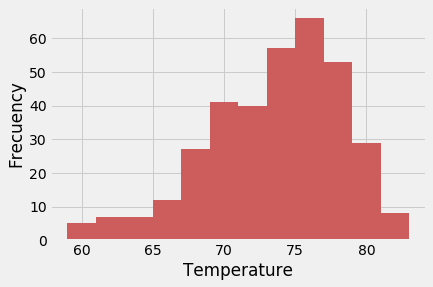

In [197]:
# Load the information as df
df_temperature_281 = pd.DataFrame(temperature_281, columns = ['Temperature'])

# Turns the temperature information into a Series to plot
temperature_sample = df_temperature_281['Temperature']

# Temperature Histogram
plt.hist(temperature_sample, color="indianred", bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frecuency')
plt.show()

## Bonus Challenge Assignment

In [205]:
from scipy import stats
from numpy import mean

In [ ]:
# Temperature Analysis I

# Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

# Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.




In [218]:
# June temperature 
june = "06"
june_temperature = session.query(Measurement.tobs).filter(func.strftime("%m",  Measurement.date) == june).all()

# Unpack the temperature and save into list
june_temperature_list = [temperature[0] for temperature in june_temperature]

In [214]:
# June temperature average
june_mean = mean(june_temperature)
june_mean

74.94411764705882

In [221]:
# December temperature 
december = "12"
december_temperature = session.query(Measurement.tobs).filter(func.strftime("%m",  Measurement.date) == december).all()

# Unpack the temperature and save into list
december_temperature_list = [temperature[0] for temperature in december_temperature]

In [211]:
# December temperature average
december_mean = mean(december_temperature)
december_mean

71.04152933421226

In [222]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why? I use an unpaired test since there are two groups of information with differente parameters

# Unpaired (independent) t-test
stats.ttest_ind(june_temperature_list, december_temperature_list)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [198]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
